In [84]:
import numpy as np 
import idx2numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

%matplotlib inline

In [85]:
# Path to the MNIST dataset

DATA_PATH = 'C:/Users/enjul/deep_learning_course/mnist_data/'

In [86]:
# Load MNIST data

X_train = idx2numpy.convert_from_file(DATA_PATH + 'train-images-idx3-ubyte')
Y_train = idx2numpy.convert_from_file(DATA_PATH + 'train-labels-idx1-ubyte')

X_test = idx2numpy.convert_from_file(DATA_PATH + 't10k-images-idx3-ubyte')
Y_test = idx2numpy.convert_from_file(DATA_PATH + 't10k-labels-idx1-ubyte')

In [87]:
# Сheck the shape of the input data

print(f"Shape of train data: \n images: {X_train.shape} \n labels {Y_train.shape}")
print(f"Shape of test data: \n images: {X_test.shape} \n labels {Y_test.shape}")

Shape of train data: 
 images: (60000, 28, 28) 
 labels (60000,)
Shape of test data: 
 images: (10000, 28, 28) 
 labels (10000,)


In [88]:
# Function for data visialization

def visualize(X_data, Y_data, data_size):
    fig, axes = plt.subplots(2, 5, figsize=(12,5))
    axes = axes.flatten()
    idx = np.random.randint(0, data_size, size=10)
    
    for i in range(10):
        axes[i].imshow(X_data[idx[i],:].reshape(28,28), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title("Label: " + str(int(Y_data[idx[i]])), color='black', fontsize=20)
        
    plt.show()

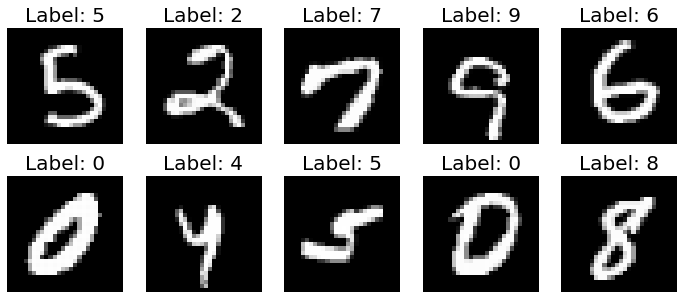

In [94]:
# Visualize some examples of input data from train

visualize(X_train, Y_train, Y_train.shape[0])

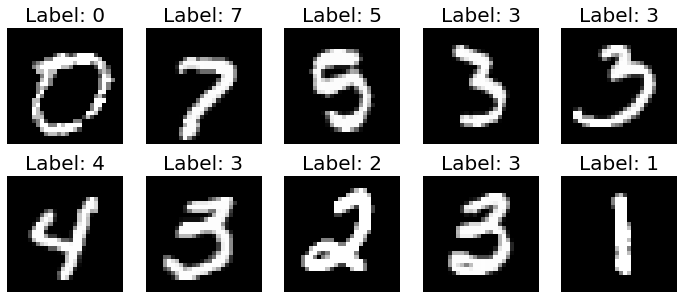

In [91]:
# Visualize some examples of input data from test

visualize(X_test, Y_test, Y_test.shape[0])

In [95]:
# Function for data preprocessing

def data_preprocess(X_data, Y_data):
    # Reshape images from train and test into 1D vector: w * h = 28 * 28 = 784
    X_data = X_data.reshape(-1, X_data.shape[1] * X_data.shape[2])
    
    # Normalize images - pixel values from 0 to 1
    X_data = X_data / 255
    
    # One-hot encoded vector for labels
    num_classes = 10 
    Y_data = np.eye(num_classes)[Y_data]
    
    return X_data, Y_data

In [96]:
# Preprocess input data

X_train, Y_train = data_preprocess(X_train, Y_train)
X_test, Y_test = data_preprocess(X_test, Y_test)

print(f"Shape of train data after reshaping: \n images: {X_train.shape}")
print(f"Shape of test data after reshaping: \n images: {X_test.shape}")

Shape of train data after reshaping: 
 images: (60000, 784)
Shape of test data after reshaping: 
 images: (10000, 784)


In [97]:
# Activation function

def ReLU(x):
    return np.maximum(0, x)

In [98]:
# Softmax

def softmax(x):
    return np.exp(x - np.max(x, axis=1, keepdims=True)) / np.sum(np.exp(x - np.max(x, axis=1, keepdims=True)), axis=1, keepdims=True)

In [99]:
# Cross Entropy function

def cross_entropy(y_pred, y_true):
    return np.mean(-np.sum(y_true * np.log(y_pred + 1e-15), axis = 1))

In [100]:
# Accuracy calculation

def calculate_accuracy(y_pred, y_true):
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis = 1))

In [101]:
# Class for Neural Network

class MnistNeuralNet:
    def __init__(self, input_size, hidden_size, output_size, lr):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr
        
        # Initialize weights (Glorot/Xavier Uniform )
        limit_1 = np.sqrt(6 / float(input_size + hidden_size))
        limit_2 = np.sqrt(6 / float(hidden_size + output_size))
        self.w_1 = np.random.uniform(low=-limit_1, high=limit_1, size=(input_size, hidden_size))
        self.w_2 = np.random.uniform(low=-limit_2, high=limit_2, size=(hidden_size, output_size))
        
        # Initialize biases
        self.b_1 = np.zeros((1, hidden_size))
        self.b_2 = np.zeros((1, output_size))

    def forward_pass(self, inputs):
        self.z_1 = np.dot(inputs, self.w_1) + self.b_1
        self.a_1 = ReLU(self.z_1)
        self.z_2 = np.dot(self.a_1, self.w_2) + self.b_2
        self.output = softmax(self.z_2)
        
        return self.output

    def backward_pass(self, inputs, labels):
        # Calculate error at output layer
        dz_2 = (self.output - labels)
        
        # Gradient for weights between hidden and output layer
        dw_2 = np.dot(self.a_1.T, dz_2) / len(self.output)
        
        # Calculate gradient for ReLU
        drelu = (self.z_1 > 0).astype(float)
        
        # Calculate error at hidden layer
        dz_1 = np.dot(dz_2, self.w_2.T) * drelu
        
        # Gradient for weights between input and hidden layer
        dw_1 = np.dot(inputs.T, dz_1)

        # Calculate gradients for biases
        db_2 = np.sum(dz_2, axis=0, keepdims=True) / len(self.output)
        db_1 = np.sum(dz_1, axis=0, keepdims=True) / len(self.output)
 
        # Update weights and biases in the opposite direction of the gradient
        self.w_1 -= lr * dw_1
        self.w_2 -= lr * dw_2
        self.b_1 -= lr * db_1
        self.b_2 -= lr * db_2

In [105]:
# Train function

def train_test_model(model, train_images, train_labels, test_images, test_labels, num_epochs, batch_size):
    print('Training started')
    num_samples = train_images.shape[0]

    for epoch in tqdm(range(num_epochs)):
        time_start = time.time()
        # Shuffle the training data
        indices = np.random.permutation(num_samples)
        shuffled_train_images = train_images[indices]
        shuffled_train_labels = train_labels[indices]

        # Iterate over mini-batches
        for i in range(0, num_samples, batch_size):
            batch_images = shuffled_train_images[i:i + batch_size]
            batch_labels = shuffled_train_labels[i:i + batch_size]

            # Forward and backward pass
            model.forward_pass(batch_images)
            model.backward_pass(batch_images, batch_labels)

        # Calculate training metrics
        train_preds = model.forward_pass(train_images)
        CE_loss = cross_entropy(train_preds, train_labels)
        accuracy = calculate_accuracy(train_preds, train_labels)
        time_end = time.time()
        duration = time_end - time_start
    
        print(f'Epoch {epoch + 1}/{num_epochs}; Loss: {CE_loss:.4f};  Accuracy: {accuracy:.4f}; Duration: {duration} sec')
        
    print('Training finished')
    # Evaluate on test set
    test_preds = model.forward_pass(test_images)
    test_loss = cross_entropy(test_preds, test_labels)
    test_accuracy = calculate_accuracy(test_preds, test_labels)

    print(f'Results on Test Data: \n Loss: {test_loss:.4f}; \n Accuracy: {test_accuracy:.2f}')

In [110]:
# Set hyperparameters

batch_size = 32
lr = 0.1 # learning rate
hidden_size = 300
num_epochs = 20
input_size = X_train.shape[1]
output_size = 10 # number of classes

In [111]:
# Initialize model, train it and test it

model = MnistNeuralNet(input_size, hidden_size, output_size, lr)
train_test_model(model, X_train, Y_train, X_test, Y_test, num_epochs, batch_size)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Training started


  5%|████▏                                                                              | 1/20 [00:07<02:15,  7.12s/it]

Epoch 1/20; Loss: 0.1282;  Accuracy: 0.9622; Duration: 7.117776870727539 sec


 10%|████████▎                                                                          | 2/20 [00:14<02:09,  7.17s/it]

Epoch 2/20; Loss: 0.1017;  Accuracy: 0.9671; Duration: 7.206127643585205 sec


 15%|████████████▍                                                                      | 3/20 [00:21<02:03,  7.24s/it]

Epoch 3/20; Loss: 0.0822;  Accuracy: 0.9733; Duration: 7.315521001815796 sec


 20%|████████████████▌                                                                  | 4/20 [00:28<01:56,  7.26s/it]

Epoch 4/20; Loss: 0.0608;  Accuracy: 0.9800; Duration: 7.287369966506958 sec


 25%|████████████████████▊                                                              | 5/20 [00:36<01:47,  7.19s/it]

Epoch 5/20; Loss: 0.0620;  Accuracy: 0.9795; Duration: 7.080240249633789 sec


 30%|████████████████████████▉                                                          | 6/20 [00:43<01:40,  7.17s/it]

Epoch 6/20; Loss: 0.0624;  Accuracy: 0.9801; Duration: 7.140009164810181 sec


 35%|█████████████████████████████                                                      | 7/20 [00:50<01:32,  7.13s/it]

Epoch 7/20; Loss: 0.0573;  Accuracy: 0.9821; Duration: 7.048094034194946 sec


 40%|█████████████████████████████████▏                                                 | 8/20 [00:57<01:25,  7.10s/it]

Epoch 8/20; Loss: 0.0691;  Accuracy: 0.9798; Duration: 7.032364130020142 sec


 45%|█████████████████████████████████████▎                                             | 9/20 [01:04<01:17,  7.09s/it]

Epoch 9/20; Loss: 0.0372;  Accuracy: 0.9878; Duration: 7.056223392486572 sec


 50%|█████████████████████████████████████████                                         | 10/20 [01:11<01:10,  7.07s/it]

Epoch 10/20; Loss: 0.0328;  Accuracy: 0.9890; Duration: 7.035218715667725 sec


 55%|█████████████████████████████████████████████                                     | 11/20 [01:18<01:03,  7.07s/it]

Epoch 11/20; Loss: 0.0296;  Accuracy: 0.9902; Duration: 7.0668559074401855 sec


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:25<00:56,  7.08s/it]

Epoch 12/20; Loss: 0.0209;  Accuracy: 0.9931; Duration: 7.105788946151733 sec


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:32<00:49,  7.07s/it]

Epoch 13/20; Loss: 0.0418;  Accuracy: 0.9859; Duration: 7.034485340118408 sec


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:39<00:42,  7.06s/it]

Epoch 14/20; Loss: 0.0199;  Accuracy: 0.9933; Duration: 7.034900665283203 sec


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:46<00:35,  7.06s/it]

Epoch 15/20; Loss: 0.0239;  Accuracy: 0.9922; Duration: 7.032527923583984 sec


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:53<00:28,  7.11s/it]

Epoch 16/20; Loss: 0.0171;  Accuracy: 0.9944; Duration: 7.221309185028076 sec


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [02:00<00:21,  7.09s/it]

Epoch 17/20; Loss: 0.0217;  Accuracy: 0.9926; Duration: 7.04390549659729 sec


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [02:07<00:14,  7.08s/it]

Epoch 18/20; Loss: 0.0190;  Accuracy: 0.9938; Duration: 7.06829833984375 sec


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:15<00:07,  7.07s/it]

Epoch 19/20; Loss: 0.0167;  Accuracy: 0.9943; Duration: 7.045592308044434 sec


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.10s/it]

Epoch 20/20; Loss: 0.0127;  Accuracy: 0.9958; Duration: 7.079160451889038 sec
Training finished
Results on Test Data: 
 Loss: 0.1552; 
 Accuracy: 0.98
